In [1089]:
%matplotlib inline

import os
import certifi
import arcpy

# set default gdal and ertifi envs (non-dev)
try:
    install_dir = arcpy.GetInstallInfo().get('InstallDir')  # get arcgis install dir
    os.environ['GDAL_DATA'] = os.path.join(install_dir, 'Resources\pedata\gdaldata')  # join to gdal install
    os.environ.setdefault("CURL_CA_BUNDLE", certifi.where())  # set certifi
except:
    arcpy.AddError('Could not get install directory for ArcGIS Pro or set certifi.')
    raise

In [2]:
# globals (dev)
FOLDER_MODULES = r'C:\Users\Lewis\Documents\GitHub\tenement-tools\modules'  
FOLDER_SHARED = r'C:\Users\Lewis\Documents\GitHub\tenement-tools\shared'
GRP_LYR_FILE = r"C:\Users\Lewis\Documents\GitHub\tenement-tools\arc\lyr\group_template.lyrx"

# set gdal global environ
import os
os.environ['GDAL_DISABLE_READDIR_ON_OPEN'] = 'EMPTY_DIR'
os.environ['CPL_VSIL_CURL_ALLOWED_EXTENSIONS '] = 'tif'
os.environ['VSI_CACHE '] = 'TRUE'
os.environ['GDAL_HTTP_MULTIRANGE '] = 'YES'
os.environ['GDAL_HTTP_MERGE_CONSECUTIVE_RANGES '] = 'YES'

# also set rasterio env variables
rasterio_env = {
    'GDAL_DISABLE_READDIR_ON_OPEN': 'EMPTY_DIR',
    'CPL_VSIL_CURL_ALLOWED_EXTENSIONS': 'tif',
    'VSI_CACHE': True,
    'GDAL_HTTP_MULTIRANGE': 'YES',
    'GDAL_HTTP_MERGE_CONSECUTIVE_RANGES': 'YES'
}

# disable future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# safe imports
import sys                  # arcgis comes with these
import datetime                 # arcgis comes with these
import numpy as np              # arcgis comes with these
import arcpy                    # arcgis comes with these
from datetime import datetime   # arcgis comes with these

# risky imports (not native to arcgis)
try:
    from osgeo import gdal
    from osgeo import ogr
    from osgeo import osr
    import tempfile
    import xarray as xr
    import dask
    import rasterio
    import pystac_client
    from odc import stac
except:
    arcpy.AddError('Python libraries xarray, dask, rasterio, pystac, or odc not installed.')
    raise

# import tools
try:
    # shared folder
    sys.path.append(FOLDER_SHARED)
    import arc, satfetcher, tools

    # module folder
    sys.path.append(FOLDER_MODULES)
    import nrt, cog_odc, cog
except:
    arcpy.AddError('Could not find tenement tools python scripts (modules, shared).')
    raise

In [3]:
import matplotlib.pyplot as plt

In [5]:
# need button to create shapefile with relevent attributes
# set a folder
# create a shapefile of polygons
# need a id field, out netcdf, platform, start/end monitor date, other

## Create monitoring areas

In [4]:
#out_folder = r'C:\Users\Lewis\Desktop\nrt_projects'
#out_filename = 'ophthalmia_monitoring'

# create a new nrt project
#arcpy.NRT_Create_Project_toolbox(out_folder, out_filename)

## User defines areas...

In [5]:
# this is up to user using usual arcgis pro tools?

## Simulate process

In [6]:
# perform sync
in_feat = r'C:\Users\Lewis\Desktop\nrt_projects\ophthalmia_monitoring.gdb\monitoring_areas'

# temp inputs
in_fmask_flags = 'Valid;Snow;Water'
in_max_cloud = 0
in_veg_idx = 'MAVI'

In [7]:
#ds_summary = execute(in_feat=r'C:\Users\Lewis\Desktop\nrt_projects\ophthalmia_monitoring.gdb\monitoring_areas',
                      #in_fmask_flags='Valid;Snow;Water',
                      #in_max_cloud=0, 
                      #in_veg_idx='MAVI', 
                      #ewmacd_method='static',
                      #keep_running=True,
                      #time_interval=30)  # 43200

### Traffic light Working

In [605]:
from math import ceil
import numpy as np
from scipy import linalg

def lowess_ag(x, y, f=2. / 3., iter=3):
    """lowess(x, y, f=2./3., iter=3) -> yest
    Lowess smoother: Robust locally weighted regression.
    The lowess function fits a nonparametric regression curve to a scatterplot.
    The arrays x and y contain an equal number of elements; each pair
    (x[i], y[i]) defines a data point in the scatterplot. The function returns
    the estimated (smooth) values of y.
    The smoothing span is given by f. A larger value for f will result in a
    smoother curve. The number of robustifying iterations is given by iter. The
    function will run faster with a smaller number of iterations.
    """
    n = len(x)
    r = int(ceil(f * n))
    h = [np.sort(np.abs(x - x[i]))[r] for i in range(n)]
    w = np.clip(np.abs((x[:, None] - x[None, :]) / h), 0.0, 1.0)
    w = (1 - w ** 3) ** 3
    
    yest = np.zeros(n)
    delta = np.ones(n)
    
    for iteration in range(iter):
        for i in range(n):
            weights = delta * w[:, i]
            b = np.array([np.sum(weights * y), np.sum(weights * y * x)])
            A = np.array([[np.sum(weights), np.sum(weights * x)],
                          [np.sum(weights * x), np.sum(weights * x * x)]])
            beta = linalg.solve(A, b)
            yest[i] = beta[0] + beta[1] * x[i]

        residuals = y - yest
        s = np.median(np.abs(residuals))
        delta = np.clip(residuals / (6.0 * s), -1, 1)
        delta = (1 - delta ** 2) ** 2

    return yest

## Load vege and change data

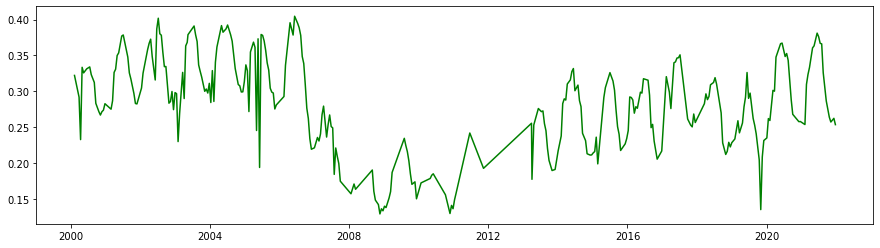

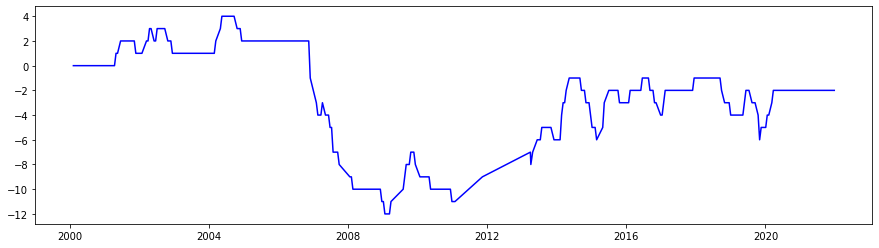

In [1127]:
ds_change = xr.open_dataset(r"C:\Users\Lewis\Desktop\test_change\change_A01.nc")  # big impact 2007 ophtha dam area
#ds_change = xr.open_dataset(r"C:\Users\Lewis\Desktop\test_change\change_A02.nc")  # big impact 2007 ophtha dam area, but training done 2013, so recovery is shown
#ds_change = xr.open_dataset(r"C:\Users\Lewis\Desktop\test_change\change_A03.nc")  # near impact 2007 ophtha dam area, less impact in 2007
#ds_change = xr.open_dataset(r"C:\Users\Lewis\Desktop\test_change\change_A04.nc")  # open shrubland with wo euc? training period bad
#ds_change = xr.open_dataset(r"C:\Users\Lewis\Desktop\test_change\change_A05.nc")  # mulga area on road side? training period bad
#ds_change = xr.open_dataset(r"C:\Users\Lewis\Desktop\test_change\change_A06.nc")  # euc vic east yandi. gradual increasing... odd result? try train period
#ds_change = xr.open_dataset(r"C:\Users\Lewis\Desktop\test_change\change_A07.nc")  # yandi discharge south veg... good, but change in training period?
#ds_change = xr.open_dataset(r"C:\Users\Lewis\Desktop\test_change\change_A08.nc")   # yandi elephatn graveyard. good - 2007 decline

vec_summary = ds_change['summary'].median(['x', 'y']).data
fig = plt.figure(figsize=(15, 4))
plt.plot(ds_change['time'].data, vec_summary, color='green')
plt.show()

vec_static = ds_change['static'].median(['x', 'y']).data
fig = plt.figure(figsize=(15, 4))
plt.plot(ds_change['time'].data, vec_static, color='blue')
plt.show()

In [1038]:
# testing
#vec_summary = ds_change['summary'].median(['x', 'y']).data

#for i in range(0, len(vec_summary)):
    #try:
        #vec = vec_summary[0:i]
    
        #x = np.arange(0, len(vec))
        #y = vec
    
        #vec_smooth = lowess_ag(x, y, f=0.05, iter=1)
        
        #fig = plt.figure(figsize=(15, 4))
        #plt.plot(vec, color='darkblue', marker='o', alpha=0.25)
        #plt.plot(vec_smooth, color='red', marker='o', alpha=0.25)
        #plt.savefig(r'C:\Users\Lewis\Desktop\smoother\smooth_{}.png'.format(i))
        
    #except:
        #continue

### Store change 


In [1039]:
# we need to store changes to a cube, because adding new images fluctuates it
# also, persistence should be low, 0.25 works ok?
# see ewmacd_arcgis python project for working

### Lowess smooth

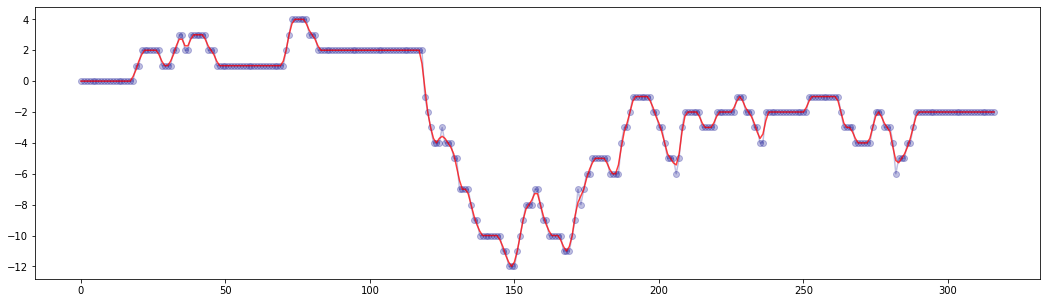

In [1136]:
#smooth & plot
vec_static_smooth = ds_change['static'].median(['x', 'y']).data

#remove positives
#vec_static_smooth = np.where(vec_static_smooth > 0, 0, vec_static_smooth)

f = 0.01 #0.01

x = np.arange(0, len(vec_static_smooth))
y = vec_static_smooth
yest = lowess_ag(x, y, f=f, iter=1)  # f is smooth %, iter is ? # default f=0.075, iter=1


fig = plt.figure(figsize=(18, 5))
plt.plot(vec_static, color='darkblue', marker='o', alpha=0.25)
plt.plot(yest, color='red', alpha=0.75)
plt.show()

### Savitsky Golay smooth

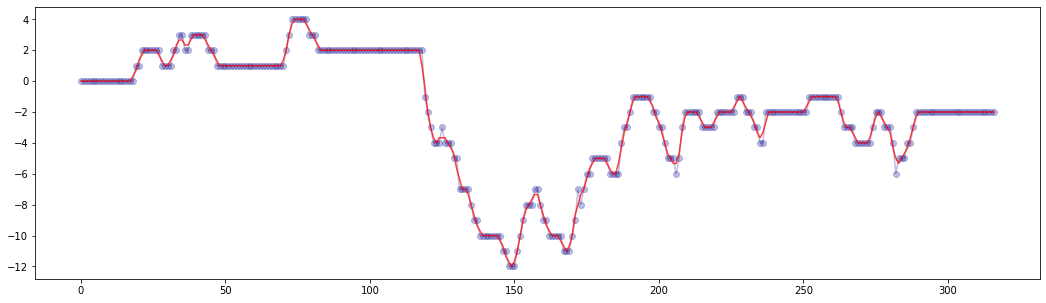

In [1137]:
from scipy.signal import savgol_filter
sav = savgol_filter(vec_static_smooth, 3, 1)

fig = plt.figure(figsize=(18, 5))
plt.plot(vec_static, color='darkblue', marker='o', alpha=0.25)
plt.plot(sav, color='red', alpha=0.75)
plt.show()

### Rule 1: n Consequitve Runs (inc, dec, stable)

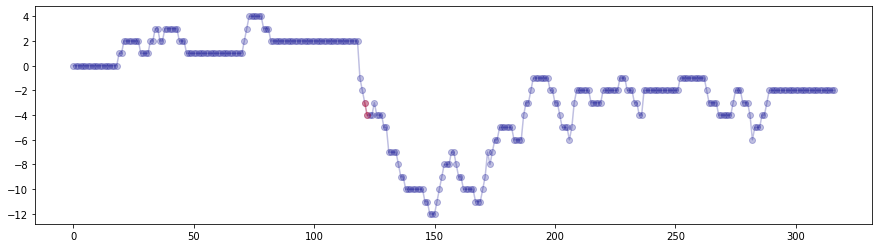

In [919]:
def apply_rule_one(arr, vector_value=-1, min_consequtives=3):
    """
    takes array of smoothed change output, classifies
    array into binary 1s 0s depending on vector value,
    calculates consequtive runs, then thresholds out 
    minimum consequtive values. note min_consequitive
    is inclusive of the value added.
    """
    
    # checks
    if vector_value not in [-1, 0, 1]:
        raise ValueError('Vector value must be -1, 0, 1.')
        
    # classify signal into -1, 0 and 1
    diffs = np.diff(arr, prepend=arr[0])
    diffs = np.where(diffs == 0, 0, diffs)  # stable (doesnt change anything, inc. for clarity)
    diffs = np.where(diffs > 0, 1, diffs)   # growth
    diffs = np.where(diffs < 0, -1, diffs)  # decline
    
    # count continuous runs for requested vector value
    arr_masked = np.where(diffs == vector_value, 1, 0)           # binarise
    arr_extended = np.concatenate(([0], arr_masked, [0]))        # pad array with empty begin and end elements
    idx = np.flatnonzero(arr_extended[1:] != arr_extended[:-1])  # get start and end indexes
    arr_extended[1:][idx[1::2]] = idx[::2] - idx[1::2]           # grab breaks, prev - current, also trim extended elements
    arr_counted = arr_extended.cumsum()[1:-1]                    # apply cumulative sum
    
    # threshold out specific run counts
    if min_consequtives is not None:
        arr_counted = np.where(arr_counted >= min_consequtives, arr_counted, 0)
                
    # replace 0s with nans
    arr_counted = np.where(arr_counted != 0, arr_counted, np.nan)
    
    return arr_counted


# get inc, dec and stable counts
cont_dec = apply_rule_one(yest, vector_value=-1, min_consequtives=3)     # decline
cont_stable = apply_rule_one(yest, vector_value=0, min_consequtives=3)   # stabile
cont_inc = apply_rule_one(yest, vector_value=1, min_consequtives=3)      # growth

fig = plt.figure(figsize=(15, 4))
plt.plot(yest, color='darkblue', marker='o', alpha=0.25)
plt.plot(np.where(cont_dec >= 1, yest, np.nan), color='red', marker='o', alpha=0.25)
plt.show()

### Rule 2: Threshold

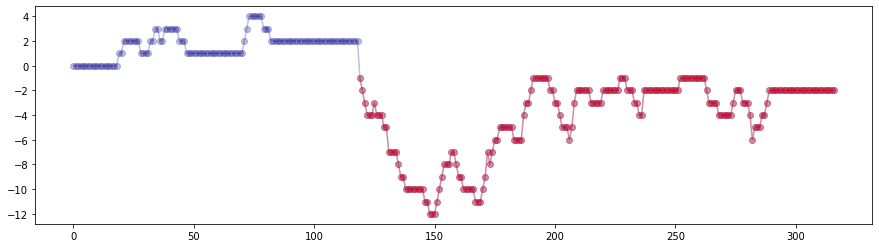

In [920]:
def apply_rule_two(arr, min_zone=-1, operator='<='):
    """
    takes array of smoothed change output and thresholds out
    any values outside of a specified minimum zone e.g. -1.
    """
    
    # checks
    if operator not in ['<', '<=', '>', '>=']:
        raise ValueError('Operator must be <, <=, >, >=')
    
    # operate based on 
    if operator == '<':
        arr_thresholded = np.where(arr < min_zone, arr, np.nan)
    elif operator == '<=':
        arr_thresholded = np.where(arr <= min_zone, arr, np.nan)
    elif operator == '>':
        arr_thresholded = np.where(arr > min_zone, arr, np.nan)
    elif operator == '>=':
        arr_thresholded = np.where(arr >= min_zone, arr, np.nan)
        
    return arr_thresholded

thresh_dec = apply_rule_two(yest, min_zone=-1, operator='<=')
thresh_inc = apply_rule_two(yest, min_zone=1, operator='>=')

fig = plt.figure(figsize=(15, 4))
plt.plot(yest, color='darkblue', marker='o', alpha=0.25)
plt.plot(thresh_dec, color='red', marker='o', alpha=0.25)
plt.show()

### Rule 3: Spike detection

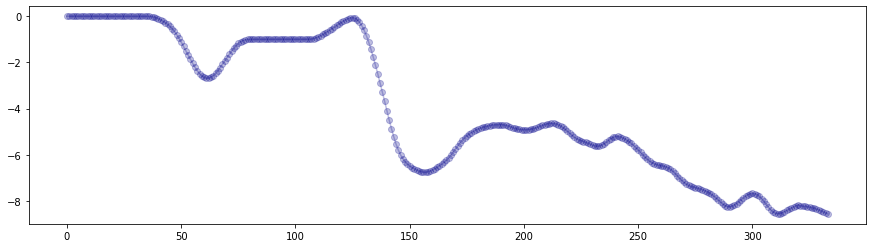

In [603]:
def apply_rule_three(arr, jump_direction='decrease', jump_size=1, min_consequtives=3, max_consequtives=3):
    """
    takes array of smoothed change output and detects large, multi zone
    jumps. candidates only registered if a specific number of post jump
    runs detected (set min_consequtives to 0 for any spike regardless of runs).
    jump_size is number of zones required to jump - default is 1 zone. max
    consequtives will cut the run off after certain number of indices detected.
    """
    
    # checks
    if jump_direction not in ['increase', 'decrease']:
        raise ValueError('Jump direction must be increase or decrease.')
        
    # prepare jump size (zone of 3 stdvs)
    if jump_size <= 0:
        print('Warning, jump size must be > 0. Resetting to one zone.')
        jump_size = 3
    else:
        jump_size = jump_size * 3
        
    # prepare max consequtives
    if max_consequtives <= 0:
        print('Warning, max consequtives must be > 0. Resetting to three.')
        max_consequtives = 3
            
    # get diffs
    diffs = np.diff(np.insert(arr, 0, arr[0]))
    
    # threshold by magnitude of jump
    if jump_direction == 'increase':
        arr_jumps = diffs > jump_size
    elif jump_direction == 'decrease':
        arr_jumps = diffs < (jump_size * -1)
        
    # iter each spike index and detect post-spike runs (as 1s)
    indices = []
    for i in np.where(arr_jumps)[0]:

        # loop each element in array from current index and calc diff
        for e, v in enumerate(arr[i:]):
            diff = np.abs(np.abs(arr[i]) - np.abs(v))

            # if diff is less than certain jump size record it, else skip
            # todo diff < 3 is check to see if stays within one zone of devs
            if diff < 3 and e <= max_consequtives:
                indices.append(i + e)
                #print('i: {} e: {} v: {} diff: {}'.format(i, e, v, round(diff, 2)))
            else:
                break 
                
    # set 1 to every flagged index, 0 to all else
    arr_masked = np.zeros_like(arr)
    arr_masked[indices] = 1
    
    # count continuous runs for requested vector value
    arr_extended = np.concatenate(([0], arr_masked, [0]))        # pad array with empty begin and end elements
    idx = np.flatnonzero(arr_extended[1:] != arr_extended[:-1])  # get start and end indexes
    arr_extended[1:][idx[1::2]] = idx[::2] - idx[1::2]           # grab breaks, prev - current, also trim extended elements
    arr_counted = arr_extended.cumsum()[1:-1]                    # apply cumulative sum
    
    # threshold out specific run counts
    if min_consequtives is not None:
        arr_counted = np.where(arr_counted >= min_consequtives, arr_counted, 0)

    # replace 0s with nans
    arr_counted = np.where(arr_counted != 0, arr_counted, np.nan)
    
    return arr_counted

        
# temp
spiked = yest.copy()
#spiked[-10: -5] = spiked[-10: -5] - 10
#spiked[25: 30] = spiked[25: 30] - 8

spike_dec = apply_rule_three(spiked, jump_direction='decrease', jump_size=1, min_consequtives=3)
spike_inc = apply_rule_three(spiked, jump_direction='increase', jump_size=1, min_consequtives=3)

#
fig = plt.figure(figsize=(15, 4))
plt.plot(spiked, color='darkblue', marker='o', alpha=0.25)
plt.plot(np.where(spike_dec >= 1, spiked, np.nan), color='red', marker='o', alpha=0.25)
plt.show()

### Combine Rule 1, 2, 3

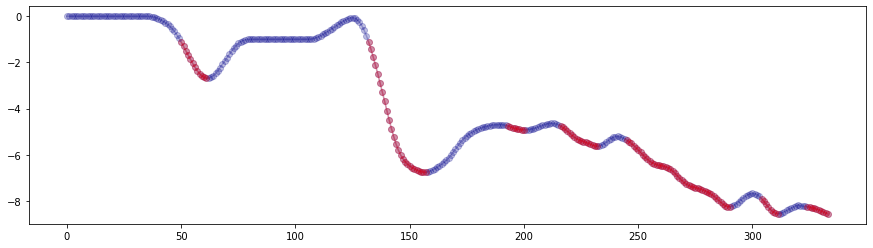

In [604]:
def combine_rules(arr_r1, arr_r2, arr_r3, ruleset='1&2|3'):
    """
    take pre-generated rule arrays and combine where requested.
    """
    
    # checks
    
    # convert rule arrays to binary masks
    arr_r1_mask = ~np.isnan(arr_r1)
    arr_r2_mask = ~np.isnan(arr_r2)
    arr_r3_mask = ~np.isnan(arr_r3)
        
    # set rule
    if ruleset == '1':
        arr_comb = np.where(arr_r1_mask, 1, 0)
    elif ruleset == '2':
        arr_comb = np.where(arr_r2_mask, 1, 0)
    elif ruleset == '3':
        arr_comb = np.where(arr_r3_mask, 1, 0)
    
    elif ruleset == '1&2':
        arr_comb = np.where(arr_r1_mask & arr_r2_mask, 1, 0)
    elif ruleset == '1&3':
        arr_comb = np.where(arr_r1_mask & arr_r3_mask, 1, 0)        
    elif ruleset == '2&3':
        arr_comb = np.where(arr_r2_mask & arr_r3_mask, 1, 0)             
        
    elif ruleset == '1|2':
        arr_comb = np.where(arr_r1_mask | arr_r2_mask, 1, 0)  
    elif ruleset == '1|3':
        arr_comb = np.where(arr_r1_mask | arr_r3_mask, 1, 0) 
    elif ruleset == '2|3':
        arr_comb = np.where(arr_r2_mask | arr_r3_mask, 1, 0)     
        
    elif ruleset == '1&2&3':  
        arr_comb = np.where(arr_r1_mask & arr_r2_mask & arr_r3_mask, 1, 0)
    elif ruleset == '1|2&3':  
        arr_comb = np.where(arr_r1_mask | (arr_r2_mask & arr_r3_mask), 1, 0)        
    elif ruleset == '1&2|3':  
        arr_comb = np.where((arr_r1_mask & arr_r2_mask) | arr_r3_mask, 1, 0)  
    elif ruleset == '1|2|3':  
        arr_comb = np.where(arr_r1_mask | arr_r2_mask | arr_r3_mask, 1, 0)
        
    return arr_comb
        

        
arr_comb = combine_rules(arr_r1=cont_dec, 
                         arr_r2=thresh_dec, 
                         arr_r3=spike_dec, 
                         ruleset='1&2|3'
                        )

fig = plt.figure(figsize=(15, 4))
plt.plot(spiked, color='darkblue', marker='o', alpha=0.25)
plt.plot(np.where(arr_comb >= 1, spiked, np.nan), color='red', marker='o', alpha=0.25)
plt.show()

### Combine rules

### Testing

## Consequitve decline testing

In [111]:
def get_zone(value):
    
    # zone 0 - stable
    if value < 0 and value >= -1:
        #print('Zone 0: between 0 and -1.')
        return 0
    
    # zone 1 - between -1, -3
    elif value < -1 and value >= -3:
        #print('Zone 1: between -1 and -3.')
        return 1
    
    # zone 2 - between -3, -5
    elif value < -3 and value >= -5:
        #print('Zone 2: between -3 and -5.')
        return 2
    
    # zone 3 - between -5, -7
    elif value < -5 and value >= -7:
        #print('Zone 3: between -5 and -7.')
        return 3
    
    # zone 4 - between -7, -9
    elif value < -7 and value >= -9:
        #print('Zone 4: between -7 and -9.')
        return 4
    
    # zone 4 - less than -9
    elif value < -9:
        #print('Zone 5: less than -9.')
        return 5
    
    # no zone
    else:
        #print('No zone.')
        return

In [112]:
# set up some globals
num_conseq = 4
zone_flagged = None

5


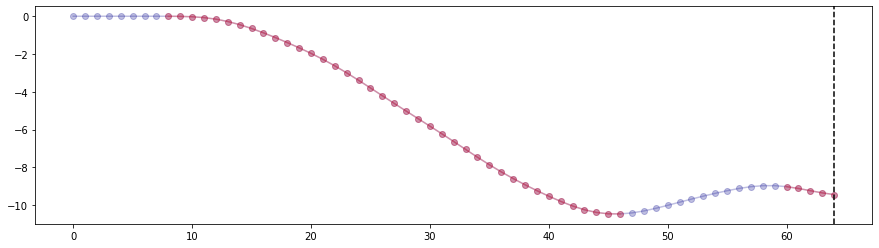

In [113]:
da = yest[100:165]

# calc diffs, make mask of 1s and 0s
diffs = np.diff(da, prepend=da[0])  # get diffs and prepend val to start
diffs = np.where(diffs < 0, 1.0, 0.0)  # convert positives to 0

# calc consequitve  negs
cons_negs = count_consequtive_negs(diffs)

# remove any consequitves under num_declines
vec = np.where(cons_negs >= 1, cons_negs, np.nan)

# get latest element
latest_change_dev = da[-1]
latest_zone = get_zone(da[-1])
latest_conseq_decline = vec[-1]

# plot
fig = plt.figure(figsize=(15, 4))
plt.plot(da, color='darkblue', marker='o', alpha=0.25)
plt.plot(np.where(~np.isnan(vec), da, np.nan), color='red', marker='o', alpha=0.25)

# detect early decline
if latest_zone == 0 and latest_conseq_decline > num_conseq:
    if zone_flagged != 0:
        plt.axvline(x=len(da) - 1, color='green', linestyle='--')
        zone_flagged = 0
        
elif latest_zone == 1 and latest_conseq_decline > num_conseq:
    if zone_flagged != 1:
        plt.axvline(x=len(da) - 1, color='yellow', linestyle='--')
        zone_flagged = 1
        
elif latest_zone == 2 and latest_conseq_decline > num_conseq:
    if zone_flagged != 2:
        plt.axvline(x=len(da) - 1, color='orange', linestyle='--')
        zone_flagged = 2
        
elif latest_zone == 3 and latest_conseq_decline > num_conseq:
    if zone_flagged != 3:
        plt.axvline(x=len(da) - 1, color='red', linestyle='--')
        zone_flagged = 3

elif latest_zone == 4 and latest_conseq_decline > num_conseq:
    if zone_flagged != 4:
        plt.axvline(x=len(da) - 1, color='darkred', linestyle='--')
        zone_flagged = 4
        
elif latest_zone == 5 and latest_conseq_decline > num_conseq:
    if zone_flagged != 5:
        plt.axvline(x=len(da) - 1, color='black', linestyle='--')
        zone_flagged = 5
        
# notify of flag
print(zone_flagged)
        
# reset flag if we leave consequitve
if np.isnan(latest_conseq_decline): 
    zone_flagged = None

plt.show()

## Combining rules

In [29]:
-3 <= -2

True

In [268]:
def determine_flag(arr, max_consequitive_declines=4):
    """
    """
    
    # checks
    #
    
    # notify
    #
    
    # calc differences between each value, make binary mask
    diffs = np.diff(arr, prepend=arr[0])      # get diffs, prepend val to start
    diffs = np.where(diffs < 0, 1.0, 0.0)   # convert positives to 0
    
    # calculate consequitve  negs
    cons_negs = count_consequtive_negs(diffs)

    # set any non-consequitve values to nan
    vec = np.where(cons_negs >= 1, cons_negs, np.nan)
    
    # extract latest change value, zone and consequitve value
    new_change_dev = arr[-1]
    new_zone = get_zone(arr[-1])
    new_conseq_decline = vec[-1]
    
    # notify
    print('Latest deviation: {}, in zone: {}, consequitive: {}.'.format(new_change_dev, 
                                                                        new_zone, 
                                                                        new_conseq_decline))
    
    # plot (temporary)
    fig = plt.figure(figsize=(15, 4))
    plt.plot(arr, color='darkblue', marker='o', alpha=0.25)
    plt.plot(np.where(~np.isnan(vec), arr, np.nan), color='red', marker='o', alpha=0.25)
    
    
    # classify latest observation
    if new_zone == 0 and new_conseq_decline > num_conseq:
        plt.axvline(x=len(arr) - 1, color='yellow', linestyle='--')

    elif new_zone == 1 and new_conseq_decline > num_conseq:
        plt.axvline(x=len(arr) - 1, color='orange', linestyle='--')

    elif new_zone == 2 and new_conseq_decline > num_conseq:
        plt.axvline(x=len(arr) - 1, color='orangered', linestyle='--')

    elif new_zone == 3 and new_conseq_decline > num_conseq:
        plt.axvline(x=len(arr) - 1, color='red', linestyle='--')

    elif new_zone == 4 and new_conseq_decline > num_conseq:
        plt.axvline(x=len(arr) - 1, color='firebrick', linestyle='--')

    elif new_zone == 5 and new_conseq_decline > num_conseq:
        plt.axvline(x=len(arr) - 1, color='saddlebrown', linestyle='--')
    
    # show plot
    #plt.show()
    fn = datetime.now().strftime("%H:%M:%S:%f").replace(':', '')
    fn = os.path.join(r'C:\Users\Lewis\Desktop\output', fn + '.jpg')
    plt.savefig(fn)
    plt.close()
    
    # plot empty line
    #print()

In [269]:
for i in range(0, len(yest)):
    try:
        da = yest[0:i]
        determine_flag(arr=da)
    except:
        print('issue')

issue
Latest deviation: 0.0, in zone: None, consequitive: nan.
Latest deviation: 0.0, in zone: None, consequitive: nan.
Latest deviation: 0.0, in zone: None, consequitive: nan.
Latest deviation: 0.0, in zone: None, consequitive: nan.
Latest deviation: 0.0, in zone: None, consequitive: nan.
Latest deviation: 0.0, in zone: None, consequitive: nan.
Latest deviation: 0.0, in zone: None, consequitive: nan.
Latest deviation: 0.0, in zone: None, consequitive: nan.
Latest deviation: 0.0, in zone: None, consequitive: nan.
Latest deviation: 0.0, in zone: None, consequitive: nan.
Latest deviation: 0.0, in zone: None, consequitive: nan.
Latest deviation: 0.0, in zone: None, consequitive: nan.
Latest deviation: 0.0, in zone: None, consequitive: nan.
Latest deviation: 0.0, in zone: None, consequitive: nan.
Latest deviation: 0.0, in zone: None, consequitive: nan.
Latest deviation: 0.0, in zone: None, consequitive: nan.
Latest deviation: 0.0, in zone: None, consequitive: nan.
Latest deviation: 0.0, in

Latest deviation: -1.3475142136048213, in zone: 1, consequitive: nan.
Latest deviation: -1.3178327966057939, in zone: 1, consequitive: nan.
Latest deviation: -1.3157021754535672, in zone: 1, consequitive: nan.
Latest deviation: -1.3444101234718326, in zone: 1, consequitive: 1.0.
Latest deviation: -1.4072853697975525, in zone: 1, consequitive: 2.0.
Latest deviation: -1.5059168301118255, in zone: 1, consequitive: 3.0.
Latest deviation: -1.6389151440275214, in zone: 1, consequitive: 4.0.
Latest deviation: -1.8017919103757478, in zone: 1, consequitive: 5.0.
Latest deviation: -1.9875615110084297, in zone: 1, consequitive: 6.0.
Latest deviation: -2.187210730513023, in zone: 1, consequitive: 7.0.
Latest deviation: -2.389164287719616, in zone: 1, consequitive: 8.0.
Latest deviation: -2.581466096928459, in zone: 1, consequitive: 9.0.
Latest deviation: -2.753186892860924, in zone: 1, consequitive: 10.0.
Latest deviation: -2.8967731738997458, in zone: 1, consequitive: 11.0.
Latest deviation: -3.0

## Rates

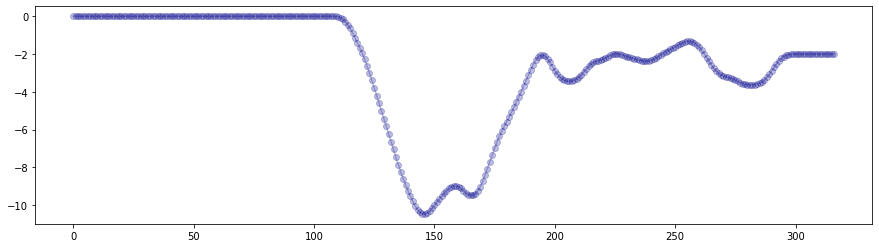

In [138]:
fig = plt.figure(figsize=(15, 4))
plt.plot(yest, color='darkblue', marker='o', alpha=0.25)
plt.show()

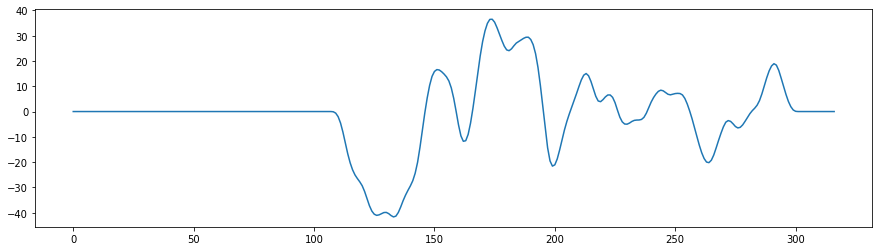

In [343]:
# (value_new - value_old) / (time_new - time_old)

yest_diffs = np.diff(yest)
yest_diffs = np.insert(yest_diffs, 0, 0)

dts = np.arange(0, len(yest))
time_diffs = np.diff(dts)
time_diffs = np.insert(time_diffs, 0, 1)

rate_of_change = (yest_diffs / time_diffs) * 100

fig = plt.figure(figsize=(15, 4))
plt.plot(rate_of_change)
plt.show()

## Clean spikes

In [1091]:
vec_static = ds_change['static'].median(['x', 'y']).data
arr = vec_static.copy()

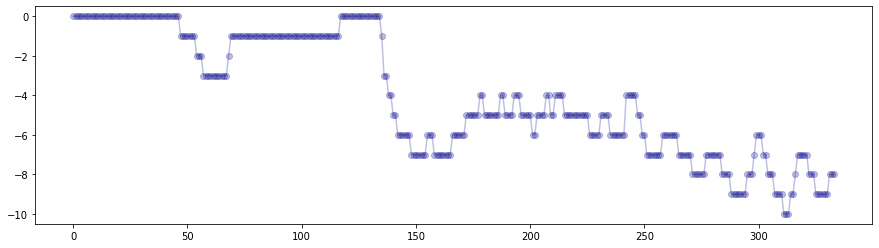

In [1092]:
def clean_singular_spikes(arr):
    """
    this is a basic function that takes a time series
    array (1d) and checks for any instances where a middle
    value is different than two values on either side. the
    two surrouding values must have the exact same value. this
    method is only helpful on removing minor noise from a
    ewmacd change detection output, which only ever increases
    in whole numbers i.e. -1 to -2 to -1. Can repeat multiple times.
    """

    # iter each value in array (exclude first and last elem)
    for i in np.arange(1, len(arr) - 1):

        # check if left value is same as right
        if arr[i - 1] == arr[i + 1]:

            # if the middle num doesnt match, set to left value
            if arr[i] != arr[i - 1]:
                arr[i] = arr[i - 1]
                    
    return arr

# cleaned of spikes
arr = clean_singular_spikes(arr)

fig = plt.figure(figsize=(15, 4))
#plt.plot(vec_static, color='darkblue', marker='o', alpha=0.25)
plt.plot(arr, color='darkblue', marker='o', alpha=0.25)
#plt.plot(np.where(arr != vec_static, vec_static, np.nan), color='red', marker='o', alpha=0.25)
plt.show()

## Testing rule 1 alternative

In [1085]:
def fill_zeros_with_last(arr):
    prev = np.arange(len(arr))
    prev[arr == 0] = 0
    prev = np.maximum.accumulate(prev)
    
    return arr[prev]

diffs = np.diff(arr, prepend=arr[0])
diffs = fill_zeros_with_last(diffs)
diffs = np.where(diffs < 0, -1, 0)  # decline

In [1086]:
vector_value = -1
min_consequtives = 0

# count continuous runs for requested vector value
arr_masked = np.where(diffs == vector_value, 1, 0)           # binarise
arr_extended = np.concatenate(([0], arr_masked, [0]))        # pad array with empty begin and end elements
idx = np.flatnonzero(arr_extended[1:] != arr_extended[:-1])  # get start and end indexes
arr_extended[1:][idx[1::2]] = idx[::2] - idx[1::2]           # grab breaks, prev - current, also trim extended elements
arr_counted = arr_extended.cumsum()[1:-1]                    # apply cumulative sum

# threshold out specific run counts
if min_consequtives is not None:
    arr_counted = np.where(arr_counted >= min_consequtives, arr_counted, 0)

# replace 0s with nans
arr_counted = np.where(arr_counted != 0, arr_counted, np.nan)

#return arr_counted

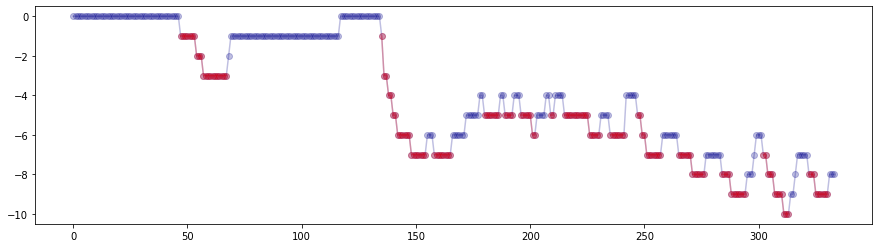

In [1087]:
fig = plt.figure(figsize=(15, 4))
plt.plot(arr, color='darkblue', marker='o', alpha=0.25)
#plt.plot(np.where(diffs == -1, arr, np.nan), color='orange', marker='o', alpha=0.25)
plt.plot(np.where(~np.isnan(arr_counted), arr, np.nan), color='red', marker='o', alpha=0.25)
plt.show()

In [753]:
indices

[28, 29, 30]

In [671]:
# iter each spike index and detect post-spike runs (as 1s)
indices = []
for i in np.where(arr_jumps)[0]:

    # loop each element in array from current index and calc diff
    for e, v in enumerate(arr[i:]):
        diff = np.abs(np.abs(arr[i]) - np.abs(v))

        # if diff is less than certain jump size record it, else skip
        # todo diff < 3 is check to see if stays within one zone of devs
        if diff < 3 and e <= max_consequtives:
            indices.append(i + e)
            #print('i: {} e: {} v: {} diff: {}'.format(i, e, v, round(diff, 2)))
        else:
            break 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [668]:
for i in np.arange(1, len(arr)):
    diff = arr[i - 1] - arr[i]
    print(diff)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.0
0.0
-1.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
-1.0
0.0
-1.0
0.0
1.0
0.0
-1.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.0
-1.0
-1.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3.0
1.0
1.0
1.0
0.0
0.0
-1.0
1.0
0.0
0.0
1.0
0.0
2.0
0.0
0.0
0.0
1.0
1.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
1.0
0.0
0.0
-1.0
-1.0
-1.0
-1.0
0.0
0.0
-1.0
0.0
1.0
1.0
0.0
1.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
-1.0
-1.0
-2.0
1.0
-1.0
-1.0
0.0
-1.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
-2.0
-1.0
0.0
-1.0
-1.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
1.0
0.0
1.0
1.0
0.0
0.0
1.0
-1.0
-2.0
-1.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
-1.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.0
0.0
0.0
1.0
0.0
0.0
1.0
0.0
1.0
0.0
-2.0
0.0
0.0
0.0
0.0
0.0
0.

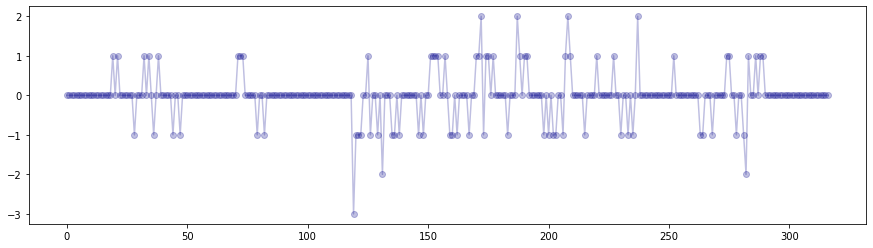

In [663]:
fig = plt.figure(figsize=(15, 4))
plt.plot(diffs, color='darkblue', marker='o', alpha=0.25)
plt.show()

In [662]:
diffs

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,
        0.,  0., -1.,  0.,  0.,  0.,  1.,  0.,  1.,  0., -1.,  0.,  1.,
        0.,  0.,  0.,  0.,  0., -1.,  0.,  0., -1.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,
        0., -1.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0., -3., -1., -1., -1.,  0.,  0.,  1., -1.,  0.,  0., -1.,
        0., -2.,  0.,  0.,  0., -1., -1.,  0., -1.,  0.,  0.,  0.,  0.,
        0.,  0.,  0., -1.,  0., -1.,  0.,  0.,  1.,  1.,  1.,  1.,  0.,
        0.,  1.,  0., -1., -1.,  0., -1.,  0.,  0.,  0.,  0., -1.,  0.,
        0.,  1.,  1.,  2., -1.,  1.,  1.,  0.,  1.,  0.,  0.,  0

In [ ]:
def apply_rule_one(arr, vector_value=-1, min_consequtives=None):
    """
    takes array of smoothed change output, classifies
    array into binary 1s 0s depending on vector value,
    calculates consequtive runs, then thresholds out 
    minimum consequtive values. note min_consequitive
    is inclusive of the value added.
    """
    
    # checks
    if vector_value not in [-1, 0, 1]:
        raise ValueError('Vector value must be -1, 0, 1.')
        
    # classify signal into -1, 0 and 1
    diffs = np.diff(arr, prepend=arr[0])
    diffs = np.where(diffs == 0, 0, diffs)  # stable (doesnt change anything, inc. for clarity)
    diffs = np.where(diffs > 0, 1, diffs)   # growth
    diffs = np.where(diffs < 0, -1, diffs)  # decline
    
    # count continuous runs for requested vector value
    arr_masked = np.where(diffs == vector_value, 1, 0)           # binarise
    arr_extended = np.concatenate(([0], arr_masked, [0]))        # pad array with empty begin and end elements
    idx = np.flatnonzero(arr_extended[1:] != arr_extended[:-1])  # get start and end indexes
    arr_extended[1:][idx[1::2]] = idx[::2] - idx[1::2]           # grab breaks, prev - current, also trim extended elements
    arr_counted = arr_extended.cumsum()[1:-1]                    # apply cumulative sum
    
    # threshold out specific run counts
    if min_consequtives is not None:
        arr_counted = np.where(arr_counted >= min_consequtives, arr_counted, 0)
                
    # replace 0s with nans
    arr_counted = np.where(arr_counted != 0, arr_counted, np.nan)
    
    return arr_counted


# get inc, dec and stable counts
cont_dec = apply_rule_one(yest, vector_value=-1, min_consequtives=4)     # decline
cont_stable = apply_rule_one(yest, vector_value=0, min_consequtives=4)   # stabile
cont_inc = apply_rule_one(yest, vector_value=1, min_consequtives=4)      # growth

fig = plt.figure(figsize=(15, 4))
plt.plot(yest, color='darkblue', marker='o', alpha=0.25)
plt.plot(np.where(cont_dec >= 1, yest, np.nan), color='red', marker='o', alpha=0.25)
plt.show()